In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tabulate import tabulate
import sys
import copy
sys.path.append('C:\\Users\\chery\\Documents\\SeattlePolice911Response')
from utils.baseML import BaseML
from datetime import datetime
from sklearn import preprocessing

In [3]:
spir = BaseML("Processed SPIR Data/SPIR_encoded_2021116.csv")

In [4]:
spir.df.columns

Index(['Unnamed: 0', 'Event Clearance Code', 'Event Clearance Description',
       'Event Clearance SubGroup', 'Event Clearance Group', 'Census Tract',
       'Initial Type Description', 'Initial Type Subgroup',
       'Initial Type Group', 'at_scene_time', 'event_clear_time',
       'time_at_scene', 'white', 'total_pop', 'male', 'notUScitizen', 'asian',
       'black', 'native', 'other_race', 'two_races', 'some_college',
       'bachelors', 'grad_deg', 'under18MC', 'under18MS', 'under18FS',
       'under18T', 'income', 'initial_type_desc_cat', 'at_scene_time_pm',
       'event_clear_time_pm', 'at_scene_time_weekday',
       'event_clear_time_weekday', 'at_scene_time_month',
       'event_clear_time_month', 'at_scene_time_year', 'event_clear_time_year',
       'time_at_scene_seconds'],
      dtype='object')

In [5]:
spir_process = spir.df.drop(['Unnamed: 0', "Event Clearance Description", "Event Clearance SubGroup", "Event Clearance Group", 
"Initial Type Subgroup", "Initial Type Group",
'Initial Type Description', 'at_scene_time', 'event_clear_time', 'time_at_scene'], axis=1)

In [6]:
from scipy import stats
spir_process= spir_process[(np.abs(stats.zscore(spir_process)) < 3).all(axis=1)]

In [7]:
print(len(spir_process))

331764


In [8]:
spir_baseML = BaseML()
spir_baseML.df = spir_process

In [9]:
spir_process = spir_baseML.normalize_features()

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(spir_process)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
x_pca=pca.fit_transform(spir_process)

[0.15527427 0.08884775]
[802.38519135 606.95483973]


In [11]:
from sklearn.cluster import DBSCAN
clf = DBSCAN(eps=0.5).fit(x_pca) #eps=0.1 runs pretty quickly. 0.3 takes ~15 minutes. 0.5 will crash
#y_pred_4 = clf.fit_predict(x_pca)

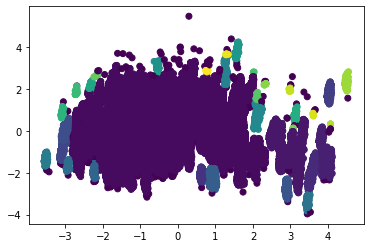

In [14]:
plt.scatter(x_pca[:,0], x_pca[:,1], c=clf.labels_)
plt.show()

In [110]:
cluster_labels = clf.labels_
cl_label_df = pd.DataFrame(cluster_labels, columns = ["cluster_label"])

In [99]:
len(cl_label_df)

331764

In [111]:
spir_process.reset_index(drop=True, inplace=True)

In [116]:
spir_with_labels = pd.concat([spir_baseML.df, cl_label_df], axis=1)
spir_with_labels.to_csv("SPIR_with_labels_20211117.csv")

In [117]:
spir_with_labels.head

<bound method NDFrame.head of         Event Clearance Code  Census Tract     white  total_pop      male  \
0                      161.0     6000.1011  0.839407     5598.0  0.471240   
1                       50.0    10300.2005  0.457715     6397.0  0.494607   
2                      430.0     2800.1003  0.910944     4907.0  0.478704   
3                       50.0     3400.3000  0.882369     3698.0  0.459167   
4                      430.0     1400.3010  0.792390     5703.0  0.497808   
...                      ...           ...       ...        ...       ...   
331759                 450.0     1200.4010  0.631122     7024.0  0.459852   
331760                 430.0     3500.3002  0.864231     4051.0  0.466058   
331761                 260.0     8100.1013  0.645320     4872.0  0.547824   
331762                 192.0     8200.1003  0.725071     4212.0  0.565052   
331763                 372.0     7200.1072  0.625254     8862.0  0.604378   

        notUScitizen     asian     black    n

In [118]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool

In [119]:
filename = "plot_bokeh_20211117.html"
palette =['aqua', 'aquamarine', 'azure', 'black', 'blue', 
        'brown', 'chartreuse', 'coral', 'crimson', 'cyan', 
        'darkblue', 'darkgreen', 'fuschsia', 'gold', 'indigo', 
        'lavender', 'lime', 'magenta', 'olive', 'orange', 
        'orangered', 'orchid', 'pink', 'red','salmon']#['red','green','blue','yellow']
colors =[]

for i in range(spir_with_labels.shape[0]):
    colors.append(palette[cluster_labels[i]])

In [120]:
#cannot use seaborn palette for bokeh

#plot with boken
output_file(filename)
source = ColumnDataSource(
        data=dict(x=x_pca[:,0],y=x_pca[:,1],
            #event = spir_with_labels['event'],
            time = spir_with_labels['time_at_scene_seconds'], 
            census_tract = spir_with_labels["Census Tract"],
            year = spir_with_labels["at_scene_time_year"],
            percent_white = spir_with_labels["white"],
            income = spir_with_labels["income"],
            college = spir_with_labels["bachelors"],
            colors=colors), )

#print(colors)
hover = HoverTool(tooltips=[
            #("event", "@event"),
            ("time", "@time"),
            ("census_tract", "@census_tract"),
            ("year", "@year"),
            ("percent_white", "@percent_white"),
            ("income", "@income"),
            ("college", "@college")])

p = figure(plot_width=1000, plot_height=1000, tools=[hover],
            title="spir clustering")

p.circle(x='x',y= 'y', size=10, source=source,fill_color="colors")

show(p)